## **Clustering**
Having cleaned and filtered our dataset, we narrowed our focus to high consumers defined as those whose bill amounts fall in the 90th percentile and above.

This focus is significant because, after consulting experts at the Nairobi Water Company, we learned that the most common driver of water loss is unbilled water. Despite widespread metering across the city, several structural challenges undermine accurate billing:

- **Busted pipes** – Water lost through leaks in the distribution network is never captured by meters, resulting in substantial unaccounted-for volumes.

- **Damaged metering systems** – When meters fail, all consumption during the downtime goes unbilled, creating revenue gaps.

- **Manual meter reading** – The reliance on manual readings introduces inefficiencies: human error in recording, skipped households or businesses, and overlooked regions. Together, these factors compound the issue of Non-Revenue Water (NRW).

To address this, the project seeks to identify hotspots of water loss and support the strategic rollout of smart metering systems. Clustering provides a powerful approach to this challenge.

By grouping high consumers into three distinct clusters, we can prioritize intervention:

- Highest consumers – the top priority for smart meter rollout, as losses here have the greatest financial impact.

- Higher consumers – secondary priority, important for scaling future rollouts.

- High consumers – still significant but not immediate rollout candidates.

Clustering is an unsupervised machine learning method that automatically groups similar data points without predefined labels. In this project, clustering not only segments consumers into the tiers above but also helps highlight outliers and reveal hidden usage patterns, both of which are critical for detecting leakages, theft, or under-billing risks

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
RANDOM_STATE = 42


Water billing example:

Normal: Usage is standard to bill.

Under-billed: High usage, low bill.

Over-billed: Low usage, high bill.


In [2]:
# Load dataset
df = pd.read_csv('../../Data/clean_data/Filtered.csv')

# Preview dataset
df.head()

,Unnamed: 0,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE
0,8,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000010,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,7771.0,0.0,7771.0,111.0,August,2024.0,False
1,11,KASARANI,HUNTERS -MWIKI,HUNTERS,CV-7000013,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,6424.0,0.0,6424.0,91.0,August,2024.0,False
2,39,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000027,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4904.0,3127.0,8031.0,71.0,August,2024.0,False
3,46,LANGATA,KAREN_LANGATA,OTIENDE LANGATA,CV-7000034,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4162.0,2716.0,6878.0,62.0,August,2024.0,False
4,56,DAGORETTI,KAWANGWARE,RIARA,CV-7000116,COM,COMMERCIAL,2.0,ACTUAL,VALID,WAT,SEW,61550.0,40458.0,102008.0,785.0,August,2024.0,False


### **Feature Selection**
Feature selection is the act of choosing the most important variables for a model. It helps improve accuracy, reduce complexity, and also avoid overfitting. At the moment we have 19 columns but to carry out our clustering, we need columns that are relevant to our question and that will help us reach the best possible answer.

We are using the following columns;
1. `WATER_AMOUNT` → this is the direct measure of consumption. Critical.

2. `SEWER_AMOUNT` → this often correlates with water usage. Could be included, but might be redundant (we'll look out for multicollinearity).

3. `BILL_AMOUNT` → how much they’re billed. Tied to water + tariffs.

4. `BILL_VOLUME` → this is another consumption proxy. If strongly correlated with WATER_AMOUNT, you might drop one to avoid redundancy.

5. `METER_SIZE` → capacity, a proxy for expected usage. Very valuable

First, to make sure we have no redundacies, we are filtering the data to have the above named columns then checking for correlation.

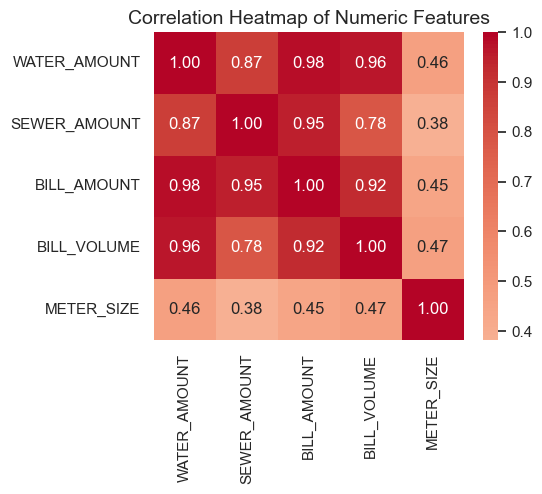

In [4]:
# Filter to remain with the above columns
clustering_data = df[['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']]

# Check correlation
num_cols = ['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

From the visualization above, we see that `WATER_AMOUNT`, `SEWER_AMOUNT`, `BILL_AMOUNT` and `BILL_VOLUME` are highly correlated with all of them having correlations above 85%. To pinpoint exactly where the multicollinearity comes from, we are using VIF (Variance Inflation Factor). 

While correlation tells us what pairs of features are similar, VIF will help us decide which ones to actually keep for clustering.

In [5]:
# drop NaNs if any
X = df[num_cols].dropna()

# add constant for VIF calculation
X_const = add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)

        Feature            VIF
0  WATER_AMOUNT   86117.235558
1  SEWER_AMOUNT   30230.987080
2   BILL_AMOUNT  205408.686340
3   BILL_VOLUME      14.974460
4    METER_SIZE       1.283845


- `BILL_AMOUNT`, `WATER_AMOUNT`, and `SEWER_AMOUNT` are almost the same information, they’re strongly derived from each other, since `BILL_AMOUNT` = `WATER_AMOUNT` + `SEWER_AMOUNT`.

- Also, `BILL_VOLUME` is somewhat correlated with the billing amounts since cost is tied to consumption, but it still contains unique info about actual consumption.

- `METER_SIZE` is independent and safe.

For clustering, we need features that:

- Aren’t redundant,

- Capture meaningful variation,

- Don’t distort distances due to duplication.

So we are using;

- `BILL_VOLUME` → consumption behavior (core driver of clustering).

- `METER_SIZE` → capacity/size of installation, different customer classes.

- `BILL_AMOUNT` → this will help us have clusters influenced by spending patterns.

### **KMeans Clustering**
In this section we are going to cluster the data using the KMean clustering function based on the features we've chosen above. Clustering will help us find groups of consumers that share patterns. This process is going to involve;
- choosing the best number of clusters

- run KMeans 

- add the cluster labels back to the original data

- interpret what each cluster means

#### **Baseline Model**
But first, for our baseline model and for easy interpretation, we are using the `BILL_AMOUNT` column to cluster first.

In [6]:
# Using one column for our baseline model
X = df[["BILL_AMOUNT"]]

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Cluster
kmeans = KMeans(random_state=42)

# Predict the clusters
clusters = kmeans.fit_predict(X_scaled)

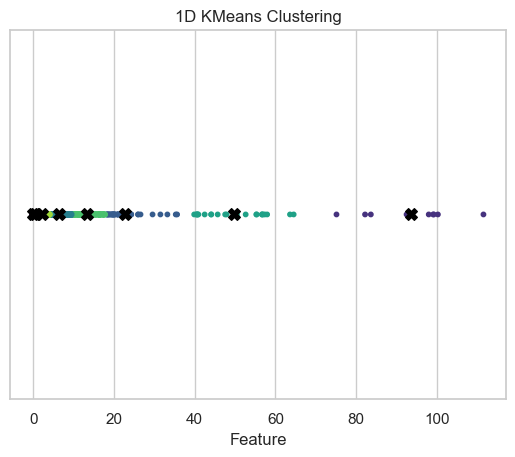

In [8]:
# Plot the clusters
centers = kmeans.cluster_centers_

# Plot the data on the x-axis, and just put zeros on y-axis
plt.scatter(X_scaled[:, 0], [0]*len(X_scaled), c=clusters, s=10, cmap='viridis')

# Plot the centers on the same line
plt.scatter(centers[:, 0], [0]*len(centers), c='black', s=70, marker='X')

plt.yticks([])  # hide y-axis ticks
plt.xlabel("Feature")
plt.title("1D KMeans Clustering")
plt.show()

The plot above shows that most data values cluster between 0–40, showing the main group.

Smaller clusters at higher values reveal outliers, which could be our targets.

#### *Choosing the best number of clusters*
In this part we'll be trying multiple values of k, that is number of clusters, and plot the inertia, how tight the groups are. We want a point where adding more clusters doesn't help much, this is the elbow method.

This will help us group the consumers into fewer groups.

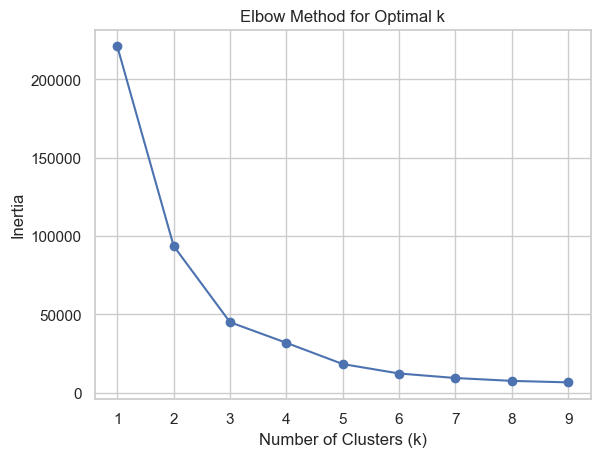

In [9]:
# Choose the best number of clusters.
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Inertia measures how far each point is from the cluster's centroid, center of the cluster. The lower the distance, the better however, if the distance is too low it might mean overfitting.

The curve bends at k=3, forming an “elbow”, indicating that `k=3` gives the best balance of accuracy and simplicity.

So, through the elbow method, we choose to have 3 cluster points.

#### *Running KMeans and Adding the clusters to the original data.*
In the code above we have performed an elbow method and have decided to have 3 cluster groups. In the next code we will be running the KMeans and adding the clusters to the original dataset.

In [10]:
# Instantiate KMeans model, using the best n_clusters value as indicated by the plot above
kmeans = KMeans(n_clusters= 3, random_state= 42)

# Fit the model and predict on scaled data
clusters = kmeans.fit_predict(X_scaled)

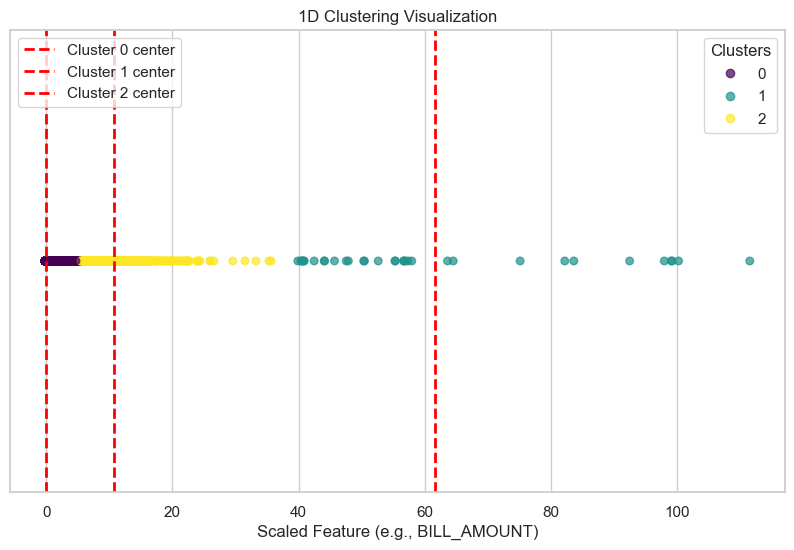

In [11]:
# Get cluster centers
centers = kmeans.cluster_centers_

# Plot the data points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_scaled, np.zeros_like(X_scaled), c=clusters, cmap='viridis', s=30, alpha=0.7)

# Plot cluster centers as vertical lines
for i, c in enumerate(centers):
    plt.axvline(x=c, color='red', linestyle='--', linewidth=2, label=f'Cluster {i} center')

# Add legend for clusters (based on scatter plot colors)
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Add legend for cluster centers
plt.legend(loc="upper left")

plt.title("1D Clustering Visualization")
plt.xlabel("Scaled Feature (e.g., BILL_AMOUNT)")
plt.yticks([])  # remove y-axis since it's meaningless in 1D
plt.show()

The plot shows:
Black crosses mark the cluster centers along the feature axis (0 to 100+).

Clusters are mostly concentrated at lower feature values, with some sparse points at higher values.

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# # 1. Silhouette Score
# silhouette = silhouette_score(X_scaled, clusters)

# 2. Calinski-Harabasz Index
calinski = calinski_harabasz_score(X_scaled, clusters)

# 3. Davies-Bouldin Index
davies = davies_bouldin_score(X_scaled, clusters)

# print(f"Silhouette Score: {silhouette:.4f} (closer to 1 is better)")
print(f"Calinski-Harabasz Index: {calinski:.2f} (higher is better)")
print(f"Davies-Bouldin Index: {davies:.4f} (closer to 0 is better)")

Calinski-Harabasz Index: 432076.77 (higher is better)
Davies-Bouldin Index: 0.4184 (closer to 0 is better)


In [13]:
# Add cluster labels to the original dataset
clustering_data['baseline_cluster'] = clusters

# preview the dataset
clustering_data.head()

,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,METER_SIZE,baseline_cluster
0,7771.0,0.0,7771.0,111.0,0.5,0
1,6424.0,0.0,6424.0,91.0,0.5,0
2,4904.0,3127.0,8031.0,71.0,0.5,0
3,4162.0,2716.0,6878.0,62.0,0.5,0
4,61550.0,40458.0,102008.0,785.0,2.0,0


In [14]:
# Count how many consumers are in clusters.
clustering_data['baseline_cluster'].value_counts()

baseline_cluster
0    220484
2       435
1        33
Name: count, dtype: int64

In [15]:
# Statistical analysis of the clusters
clustering_data.groupby('baseline_cluster').mean(numeric_only= True)

,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,METER_SIZE
baseline_cluster,,,,,
0,1.465866e+04,7.561641e+03,2.222540e+04,203.074404,0.652093
1,5.692209e+06,3.841137e+06,9.533346e+06,71168.484848,7.515152
2,1.191462e+06,4.948155e+05,1.686277e+06,16854.636782,4.358621


Looking at the averages;

- **Cluster 0**: BILL_AMOUNT ≈ 22,225

- **Cluster 1**: BILL_AMOUNT ≈ 9.5 million

- **Cluster 2**: BILL_AMOUNT ≈ 1.7 million

It is safe to assume that;

- **Cluster 1** → Highest consumers (first priority for smart meters).

- **Cluster 2** → Higher consumers (second priority).

- **Cluster 0** → High consumers (still big, but relatively small compared to the others)

Cluster counts (bar plot)

See how many consumers fall into each cluster:

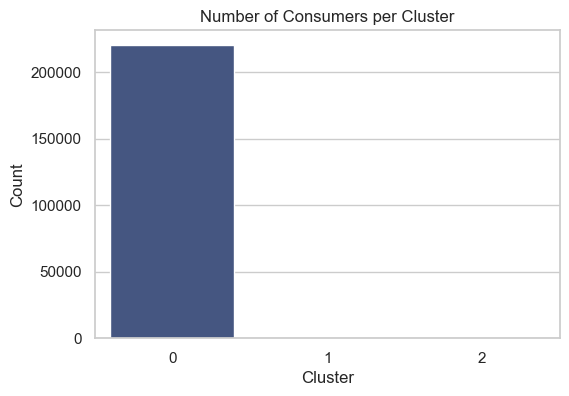

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x='baseline_cluster', data=clustering_data, palette='viridis')
plt.title("Number of Consumers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

Average values per cluster (heatmap)

Helps compare usage patterns across clusters:

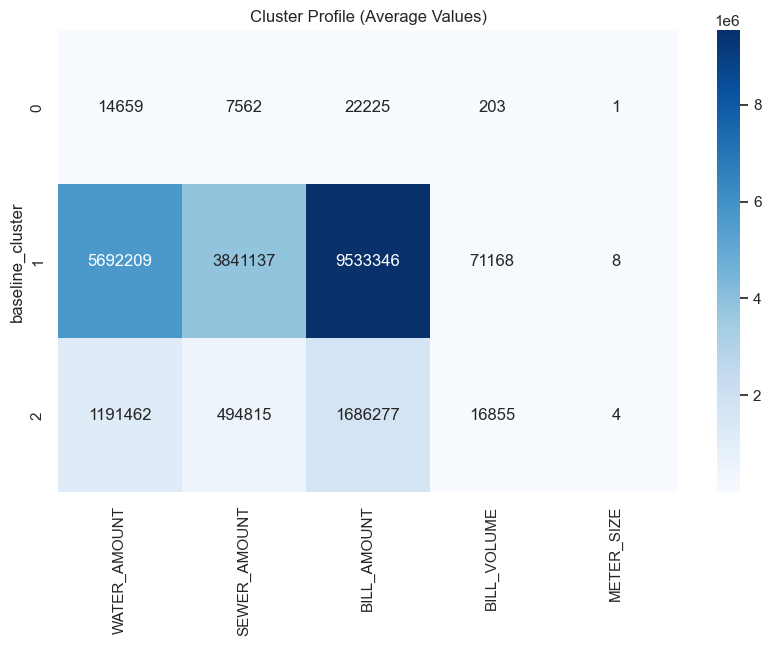

In [17]:
cluster_summary = clustering_data.groupby('baseline_cluster')[['WATER_AMOUNT','SEWER_AMOUNT','BILL_AMOUNT','BILL_VOLUME','METER_SIZE']].mean()

plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".0f", cmap="Blues")
plt.title("Cluster Profile (Average Values)")
plt.show()


Boxplots (distribution by cluster)

See how each feature is distributed across clusters:

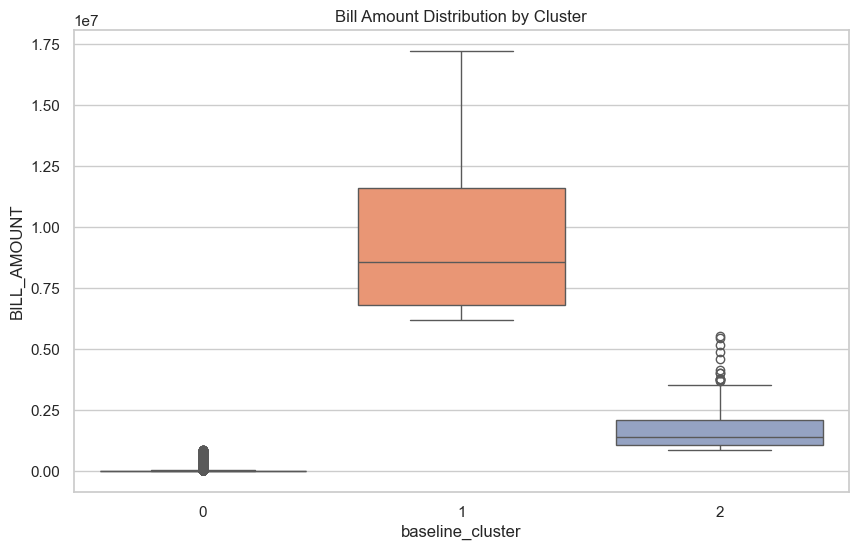

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x='baseline_cluster', y='BILL_AMOUNT', data=clustering_data, palette='Set2')
plt.title("Bill Amount Distribution by Cluster")
plt.show()

#### **Model 2**
In this part we are going to include the rest of our selected columns in our clustering, making things a little complex than they were in the previous model.

We are going to focus on 
Ways to Improve / Tune KMeans Performance

Number of clusters (n_clusters)

This is the most important one — we already saw how the elbow method and silhouette score help you pick the best value.

Initialization method (init)

Default is k-means++ (good in most cases), but you can try random too.

k-means++ is usually faster and avoids poor local minima.

Number of initializations (n_init)

KMeans runs multiple times with different initial seeds.

Default in recent sklearn versions is n_init=10, but you can increase it (say, 50) for more stable results, especially on tricky data.

Maximum iterations (max_iter)

Default is 300. If your data is complex, increasing this gives KMeans more time to converge.

Scaling & dimensionality reduction

Always scale your features (StandardScaler, MinMaxScaler).

For correlated features, you can also reduce dimensions with PCA before clustering to remove noise.

Random state

Keep it fixed for reproducibility, but you can experiment with different seeds if results vary too much.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [20]:
# Add the rest of selected columns
X = clustering_data[['BILL_VOLUME', 'BILL_AMOUNT', 'METER_SIZE']]

# Build pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),        # Step 1: scale
    ('kmeans', KMeans(random_state=42)) # Step 3: cluster
])

# Fit pipeline
kmeans_pipeline.fit(X)

# Get cluster labels
clusters = kmeans_pipeline['kmeans'].labels_


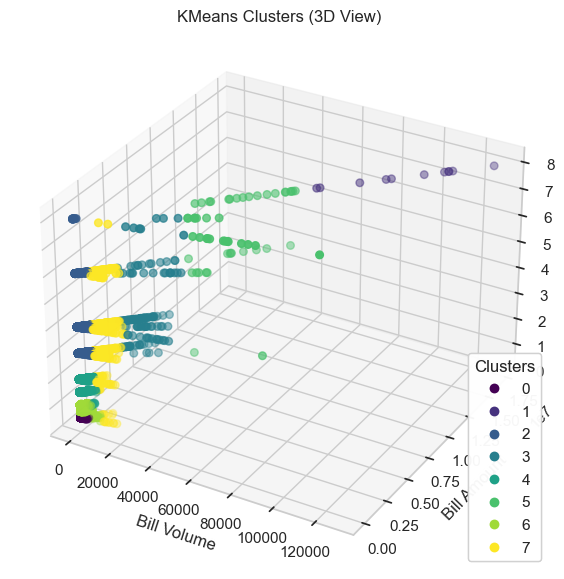

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Add cluster labels back to your data
X_plot = X.copy()
X_plot['Cluster'] = clusters

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_plot['BILL_VOLUME'], 
    X_plot['BILL_AMOUNT'], 
    X_plot['METER_SIZE'], 
    c=X_plot['Cluster'], 
    cmap='viridis',
    s=30
)

ax.set_xlabel('Bill Volume')
ax.set_ylabel('Bill Amount')
ax.set_zlabel('Meter Size')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title("KMeans Clusters (3D View)")
plt.show()


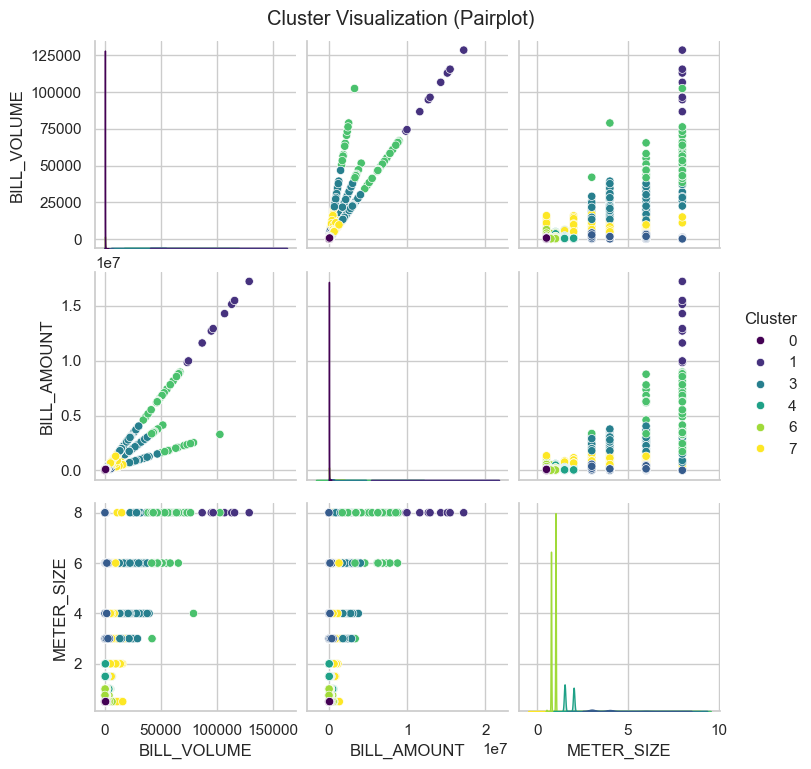

In [22]:
import seaborn as sns

sns.pairplot(X_plot, hue="Cluster", diag_kind="kde", palette="viridis")
plt.suptitle("Cluster Visualization (Pairplot)", y=1.02)
plt.show()


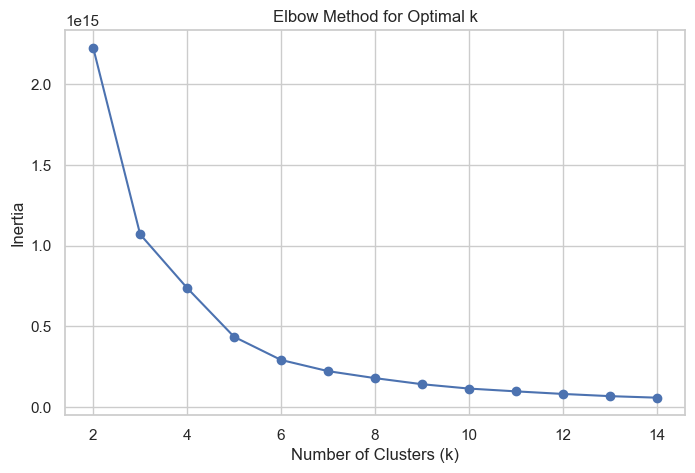

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

X = clustering_data[['BILL_VOLUME', 'BILL_AMOUNT', 'METER_SIZE']]

inertias = []
K_range = range(2, 15)  # Try clusters from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


From your plot:

The biggest drops are from k=2 → k=3 → k=4 → k=5.

After k≈5 or 6, the curve flattens — meaning adding more clusters only slightly improves inertia.

So:

Likely candidates for optimal k: 3, 4, or 5.

# HII NI KIND OF IMPORTANT

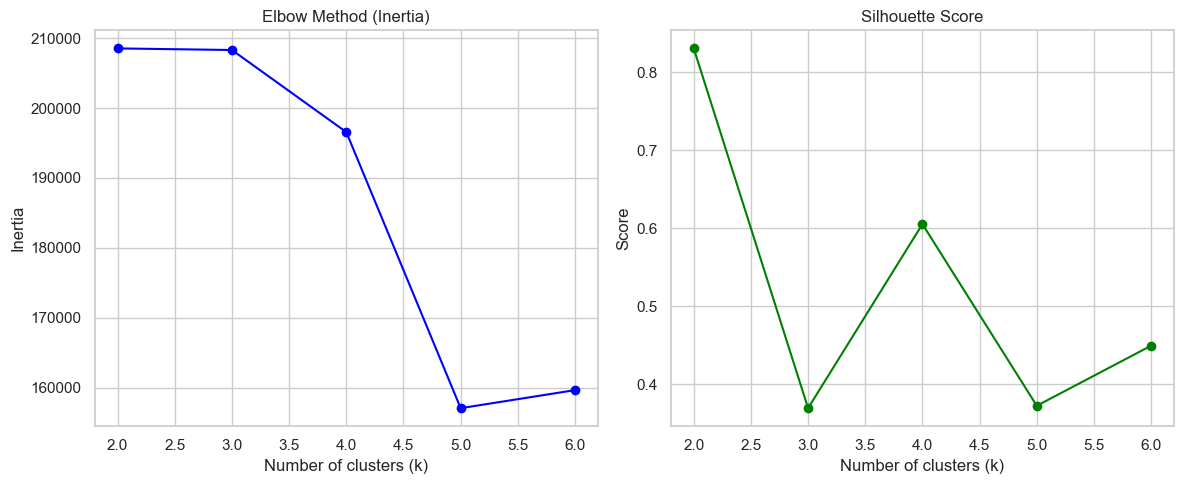

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Define range of clusters
k_values = range(2, 7)  # smaller range for speed
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(X_scaled)
    
    inertia.append(kmeans.inertia_)
    
    # silhouette with sampling for speed
    score = silhouette_score(X_scaled, kmeans.labels_, sample_size=2000, random_state=42)
    silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(12,5))

# Elbow method
plt.subplot(1,2,1)
plt.plot(k_values, inertia, 'o-', color='blue')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

# Silhouette score
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, 'o-', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


#### **Hyperparameter Tuning**

In [25]:
import itertools
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Simplified parameter grid
param_grid = {
    'n_clusters': [3, 4, 5],     
    'n_init': [10],              
    'max_iter': [300]            
}

results = []

for n_clusters, n_init, max_iter in itertools.product(
    param_grid['n_clusters'], param_grid['n_init'], param_grid['max_iter']
):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                             random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)   
    
    # Use sample size to speed up silhouette
    score = silhouette_score(X_scaled, labels, sample_size=1000, random_state=42)
    
    results.append({
        'n_clusters': n_clusters,
        'n_init': n_init,
        'max_iter': max_iter,
        'silhouette_score': score,
        'inertia': kmeans.inertia_
    })

df_results = pd.DataFrame(results).sort_values(by="silhouette_score", ascending=False)
print(df_results)


   n_clusters  n_init  max_iter  silhouette_score        inertia
0           3      10       300          0.647473  191898.052577
1           4      10       300          0.512588  178076.287706
2           5      10       300          0.409823  202070.019041


#### **Principal Component Analysis (PCA)**

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Build pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),        # Step 1: scale
    ('pca', PCA(n_components=0.95, random_state= RANDOM_STATE)),        # Step 2: reduce dimensions (optional)
    ('kmeans', KMeans(n_clusters=3, init='k-means++', n_init=50, max_iter=500, random_state=42)) # Step 3: cluster
])

# Fit pipeline
kmeans_pipeline.fit(X)

# Get cluster labels
clusters = kmeans_pipeline['kmeans'].labels_


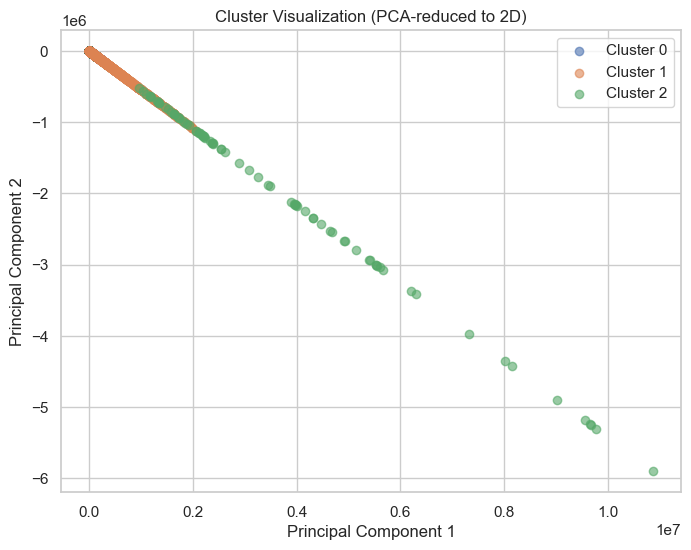

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Transform X using the pipeline steps before clustering
X_pca = kmeans_pipeline['pca'].transform(X)

# Put into a DataFrame for convenience
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = clusters

# Scatter plot
plt.figure(figsize=(8,6))
for c in df_plot['Cluster'].unique():
    plt.scatter(df_plot[df_plot['Cluster']==c]['PC1'],
                df_plot[df_plot['Cluster']==c]['PC2'],
                label=f"Cluster {c}", alpha=0.6)

plt.title("Cluster Visualization (PCA-reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X, clusters)
print("Davies-Bouldin Index:", db_score)


Davies-Bouldin Index: 0.9506851830881399


In [29]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, clusters)
print("Calinski-Harabasz Index:", ch_score)


Calinski-Harabasz Index: 137489.03341615014


In [30]:
results = []
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    labels = kmeans.fit_predict(X)
    
    results.append({
        "k": k,
        # "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels)
    })

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


   k  Calinski-Harabasz  Davies-Bouldin
0  3      432049.451799        0.418495
1  4      450897.522934        0.380616
2  5      611368.409109        0.410738


Interpretation

Calinski–Harabasz (CH)

Measures how compact and separated clusters are.

Higher is better.

✅ Here, k=5 has the highest CH score (611,368), meaning clusters are more compact and distinct at 5 clusters.

Davies–Bouldin (DB)

Measures average similarity between clusters (based on distance).

Lower is better.

✅ The best DB score is at k=4 (0.381), meaning clusters are most distinct at 4 clusters.

⚖️ Balancing Both Metrics

k=3: Decent performance, but weaker than others.

k=4: Best in DB → clusters are most well-separated, and CH is also higher than at k=3.

k=5: Best in CH → clusters are compact & distinct, but DB is slightly worse than k=4.

🎯 Recommendation

If you want clean separation of clusters (easier interpretation, clearer business story) → k=4 is stronger.

If you want maximum statistical separation (compactness, variance explained) → k=5 might be best.

Given your business case (smart meter rollout, prioritizing tiers of consumers), I’d lean towards k=4, because it’s easier to explain 4 segments than 5 to stakeholders — while still being well-separated and statistically valid

# Done improvements till here

### Cluster Selection with Calinski–Harabasz Score

- The Calinski–Harabasz (CH) score evaluates **cluster separation vs cohesion**.  
- Formula:  
  \[
  CH = \frac{\text{between-cluster dispersion}}{\text{within-cluster dispersion}}
  \]  
- **Higher is better** → well-separated, compact clusters.
- Unlike inertia, the CH score doesn’t just decrease with more clusters.  
- The "optimal k" is often where CH reaches a **maximum** or clear elbow.

**Interpretation in our case**:  
- If CH peaks at `k=3`, it means splitting regions/customers into 3 groups best balances compactness vs separation.  
- These groups can then be profiled as:  
  - Cluster 1: High consumption + high losses (priority for smart meters).  
  - Cluster 2: Moderate consumption + moderate losses.  
  - Cluster 3: Low consumption + low losses (low priority).  


k=2, Calinski-Harabasz Score=300534.11
k=3, Calinski-Harabasz Score=432076.77
k=4, Calinski-Harabasz Score=437241.52
k=5, Calinski-Harabasz Score=611452.53
k=6, Calinski-Harabasz Score=750971.03
k=7, Calinski-Harabasz Score=828827.67
k=8, Calinski-Harabasz Score=889723.54
k=9, Calinski-Harabasz Score=894139.43
k=10, Calinski-Harabasz Score=951814.31


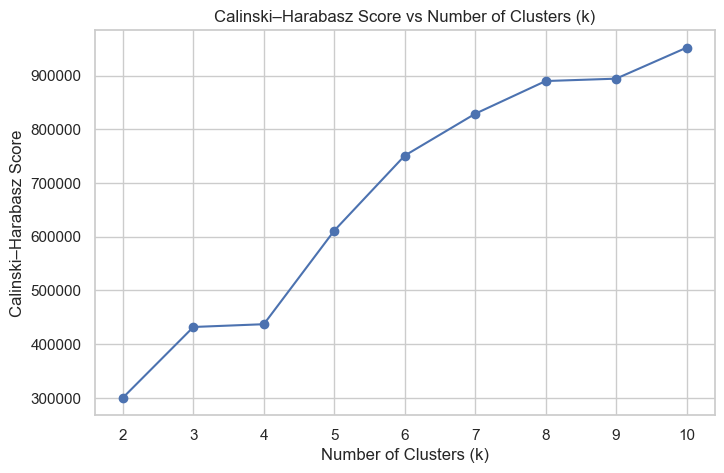

In [31]:
# Range of cluster numbers to test
k_values = range(2, 11)
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, clusters)
    scores.append(score)
    print(f"k={k}, Calinski-Harabasz Score={score:.2f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title("Calinski–Harabasz Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski–Harabasz Score")
plt.grid(True)
plt.show()


In [32]:
# Clustering based on bill amount, water amount, sewer amount and bill volume
X_clusters = df[['BILL_AMOUNT', 'BILL_VOLUME', 'SEWER_AMOUNT', 'WATER_AMOUNT']]

# preview the dataset
X_clusters.head(3)

,BILL_AMOUNT,BILL_VOLUME,SEWER_AMOUNT,WATER_AMOUNT
0,7771.0,111.0,0.0,7771.0
1,6424.0,91.0,0.0,6424.0
2,8031.0,71.0,3127.0,4904.0


In [33]:
# Scale data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_clusters)

PCA Scatter Plots by Categories

Principal Component Analysis (PCA) was applied to the billing-related numeric features (WATER_AMOUNT, SEWER_AMOUNT, BILL_AMOUNT, BILL_VOLUME).
The first two principal components (PC1 and PC2) capture most of the variance in the data, allowing us to visualize high-dimensional relationships in 2D.

To gain further insights, the data points were colored by different categorical variables:

REGION → shows how customer billing behavior varies across geographic areas. Clusters or overlaps may suggest similarities or differences in usage patterns among regions.

INST_TYPE_CODE → distinguishes between customer types (e.g., domestic vs. commercial) and highlights whether certain usage/billing patterns align with type of installation.

BILL_VALID_INVALID → separates valid vs. invalid bills, helping identify whether anomalies or errors are concentrated in specific billing patterns.

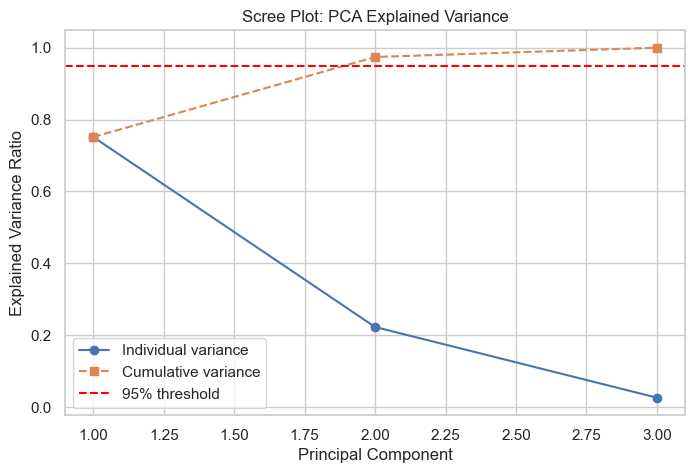

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming your billing data is in X (numeric features)
X_scaled = StandardScaler().fit_transform(X)  # standardize before PCA

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, 'o-', label="Individual variance")
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 's--', label="Cumulative variance")
plt.axhline(y=0.95, color='red', linestyle='--', label="95% threshold")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


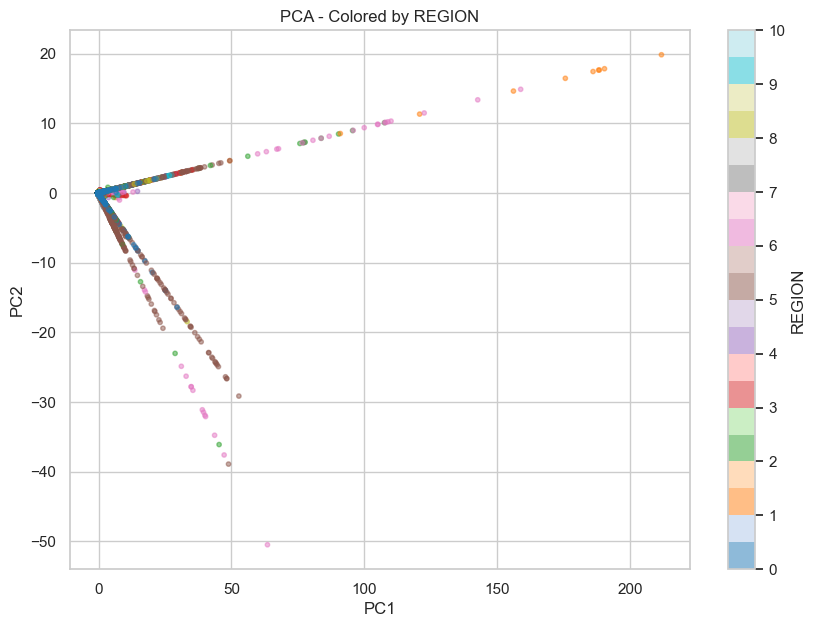

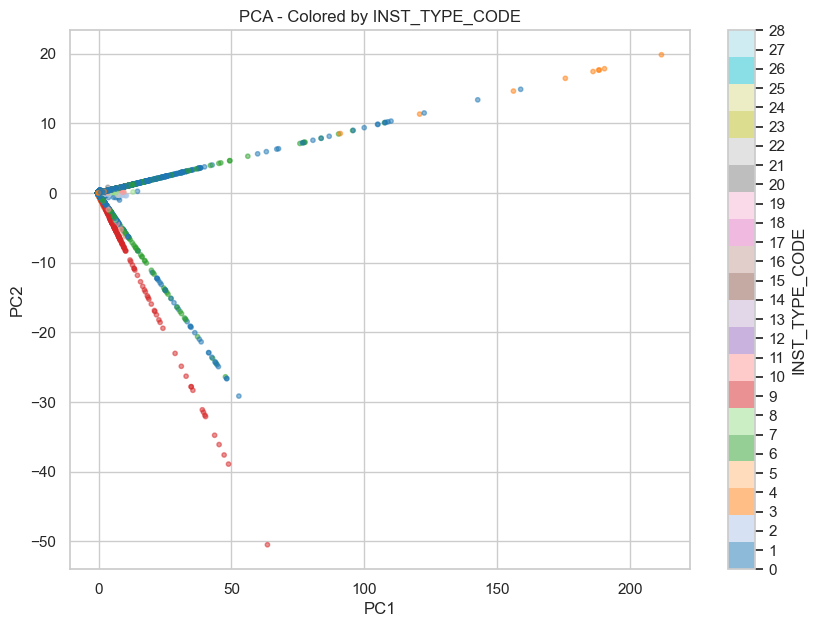

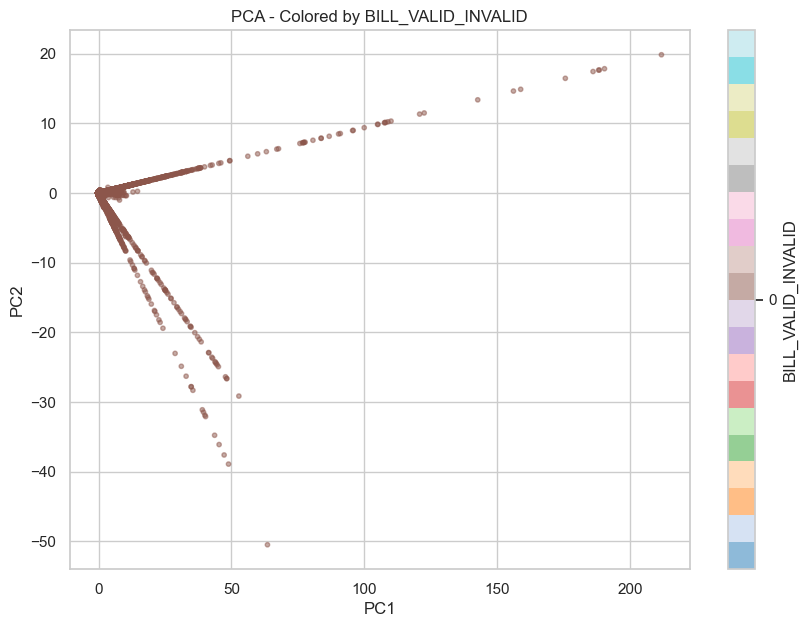

In [35]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def plot_pca_by_categories(df, features, category_cols):
    """
    Perform PCA on given numeric features and plot first two PCs,
    coloring points by multiple categorical columns.
    """
    # Select numeric features
    X = df[features].fillna(0)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    for category_col in category_cols:
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(
            X_pca[:, 0],
            X_pca[:, 1],
            c=pd.factorize(df[category_col])[0],
            cmap="tab20",
            alpha=0.5,
            s=10
        )
        plt.title(f"PCA - Colored by {category_col}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.colorbar(scatter, 
                     ticks=range(len(df[category_col].unique())), 
                     label=category_col)
        plt.show()

# Example usage:
billing_features = ["WATER_AMOUNT", "SEWER_AMOUNT", "BILL_AMOUNT", "BILL_VOLUME"]
categories_to_plot = ["REGION", "INST_TYPE_CODE", "BILL_VALID_INVALID"]

plot_pca_by_categories(df, billing_features, categories_to_plot)


In [36]:
# Apply PCA
# Import relevant class
from sklearn.decomposition import PCA

# Create a PCA object
pca_transformer = PCA(n_components= 0.95, random_state= 42)

# Transform data using pca_transformer
pca_data = pca_transformer.fit_transform(X_scaled)
pca_data

array([[-0.28807863, -0.21685855],
       [-0.30262471, -0.20947133],
       [-0.30517277, -0.20860015],
       ...,
       [-0.26747809, -0.22804657],
       [-0.16507921, -0.28096728],
       [ 0.31325602, -0.52836733]])

In [37]:
kmeans = KMeans(random_state= 42)
labels = kmeans.fit_predict(pca_data)

clusters = kmeans.transform(pca_data)

clusters

array([[4.63059665e-02, 2.49572709e+01, 6.38736472e+00, ...,
        1.05226098e+01, 1.21981679e+02, 8.02919210e-01],
       [6.26191617e-02, 2.49726526e+01, 6.39084487e+00, ...,
        1.05354006e+01, 1.21997881e+02, 8.06750084e-01],
       [6.52826774e-02, 2.49752922e+01, 6.39178563e+00, ...,
        1.05377259e+01, 1.22000574e+02, 8.07771093e-01],
       ...,
       [2.28677129e-02, 2.49353952e+01, 6.38306865e+00, ...,
        1.05046572e+01, 1.21958483e+02, 7.98602905e-01],
       [9.23984304e-02, 2.48270437e+01, 6.36083030e+00, ...,
        1.04151863e+01, 1.21844110e+02, 7.84888344e-01],
       [6.30925395e-01, 2.43217210e+01, 6.28413098e+00, ...,
        1.00042824e+01, 1.21309797e+02, 9.31095811e-01]])

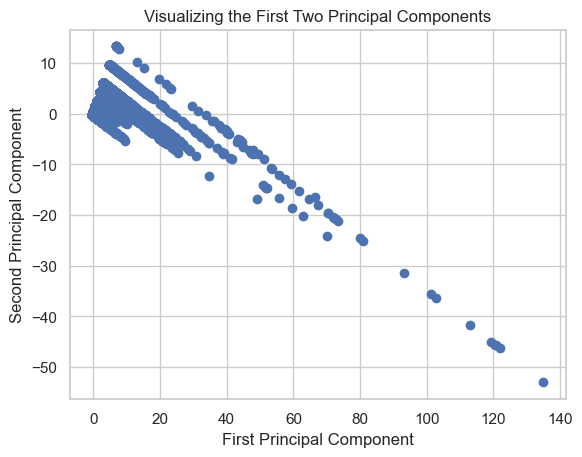

In [38]:

fig, ax = plt.subplots()
ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1])
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components");

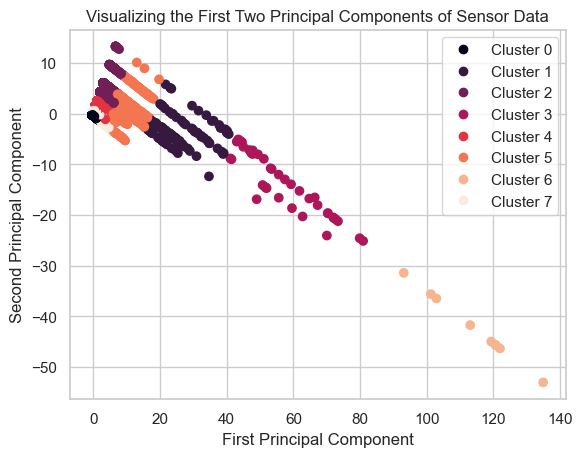

In [39]:
cluster_labels = kmeans.labels_

fig, ax = plt.subplots()

# Modify the below line of code to specify the color:
scatter = ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1], c= cluster_labels)


ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components of Sensor Data")

ax.legend(*scatter.legend_elements(fmt="Cluster {x:.0f}"));

If clusters are well-separated, you’ll see distinct groups.

Overlaps indicate clusters that are less clearly separated.

This is a 2D representation of your high-dimensional clustering, which helps to visually inspect patterns or outliers

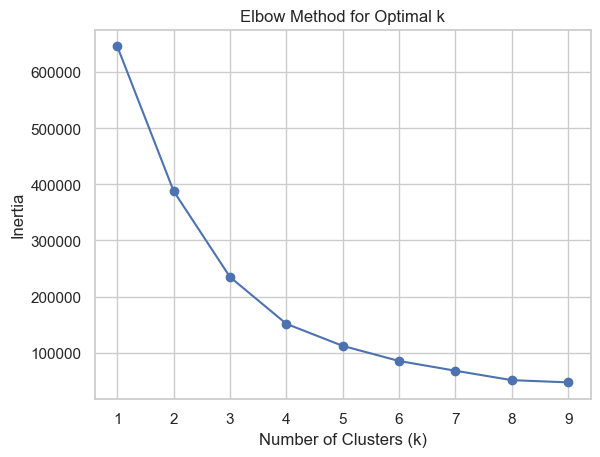

In [40]:
# Choose the best number of clusters.
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

If the plot drops sharply from k=1 to k=3 and then flattens, k=3 is likely the best number of clusters.

Choosing too few clusters can underfit (miss patterns), too many clusters can overfit (split natural groups unnecessarily).

In [41]:
kmeans = KMeans(n_clusters= 3, random_state= 42)
labels = kmeans.fit_predict(pca_data)


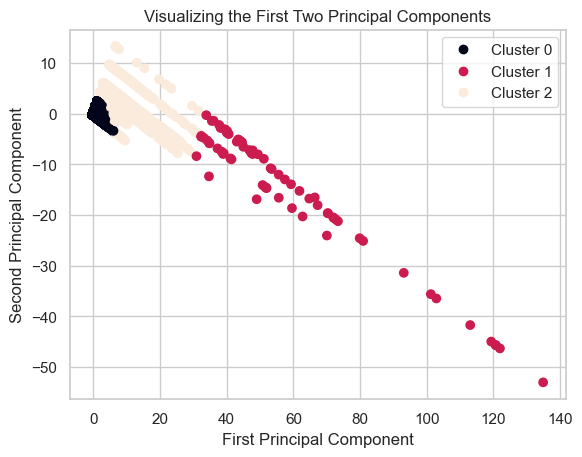

In [42]:
cluster_labels = kmeans.labels_

fig, ax = plt.subplots()

# Modify the below line of code to specify the color:
scatter = ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1], c= cluster_labels)


ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components")

ax.legend(*scatter.legend_elements(fmt="Cluster {x:.0f}"));

Well-separated colors indicate clear clusters; overlaps indicate clusters that are not strongly separated.

   k  Calinski-Harabasz  Silhouette  Davies-Bouldin
0  2       53038.495338    0.779263        0.861344
1  3       52918.992361    0.729638        0.908762
2  4       35559.245489    0.640580        0.875879
3  5       33517.502626    0.407856        1.109725
4  6       40945.001394    0.524945        0.852595
5  7       19742.640071    0.704846        0.973925
6  8       20135.799295    0.352495        0.851665
7  9       23748.807952    0.406437        0.846444


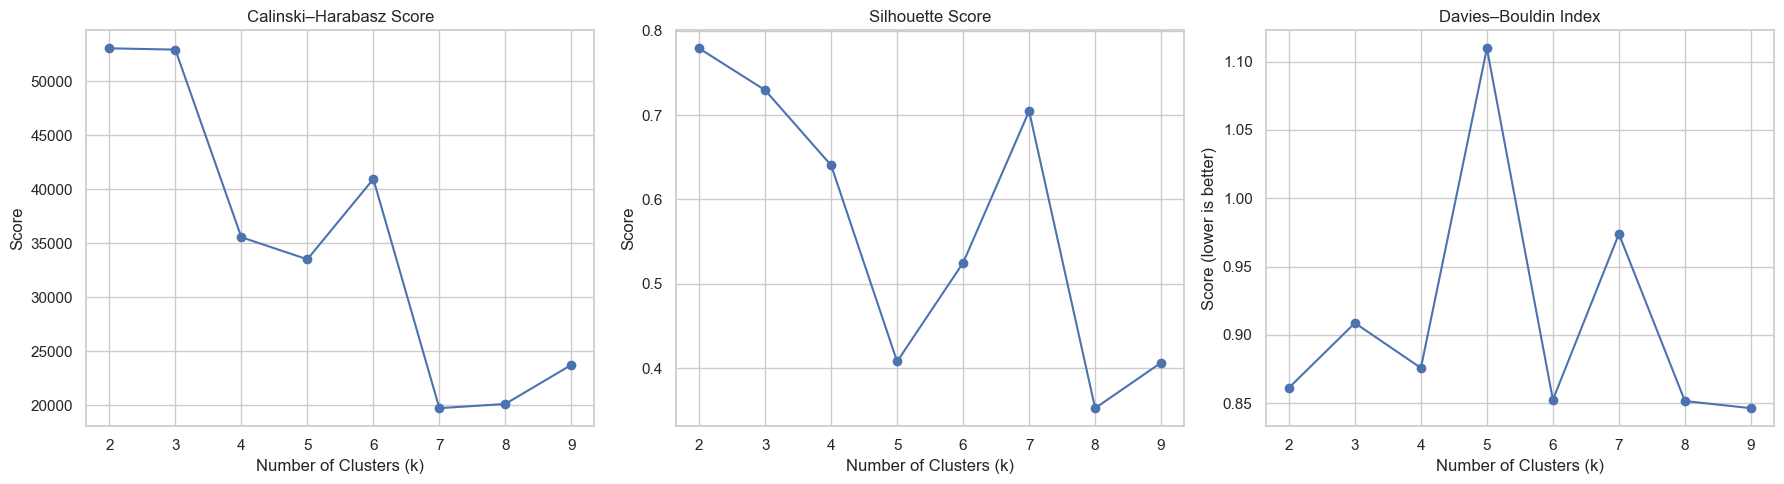

In [43]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

results = []

# loop through k values
for k in range(2, 10):   # adjust range as needed
    # Faster KMeans
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    clusters = kmeans.fit_predict(X_scaled)

    # Metrics
    ch_score = calinski_harabasz_score(X_scaled, clusters)
    db_score = davies_bouldin_score(X_scaled, clusters)

    # Sample for silhouette (fast)
    if X_scaled.shape[0] > 2000:  # only sample if dataset is large
        sample_idx = np.random.choice(len(X_scaled), size=2000, replace=False)
        sil_score = silhouette_score(X_scaled[sample_idx], clusters[sample_idx])
    else:
        sil_score = silhouette_score(X_scaled, clusters)

    results.append({
        "k": k,
        "Calinski-Harabasz": ch_score,
        "Silhouette": sil_score,
        "Davies-Bouldin": db_score
    })
# Convert to DataFrame for easier viewing
df_results = pd.DataFrame(results)

# Print results
print(df_results)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(df_results["k"], df_results["Calinski-Harabasz"], marker="o")
axs[0].set_title("Calinski–Harabasz Score")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Score")

axs[1].plot(df_results["k"], df_results["Silhouette"], marker="o")
axs[1].set_title("Silhouette Score")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Score")

axs[2].plot(df_results["k"], df_results["Davies-Bouldin"], marker="o")
axs[2].set_title("Davies–Bouldin Index")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score (lower is better)")

plt.tight_layout()
plt.show()


This plot helps you pick the “best” number of clusters by comparing multiple quality metrics visually.

In [44]:
clusters = kmeans.fit_predict(pca_data)

# Add cluster labels to the original dataset
X_clusters['BILL_CLUSTER'] = clusters

# preview the dataset
X_clusters.head()

,BILL_AMOUNT,BILL_VOLUME,SEWER_AMOUNT,WATER_AMOUNT,BILL_CLUSTER
0,7771.0,111.0,0.0,7771.0,8
1,6424.0,91.0,0.0,6424.0,1
2,8031.0,71.0,3127.0,4904.0,1
3,6878.0,62.0,2716.0,4162.0,6
4,102008.0,785.0,40458.0,61550.0,2


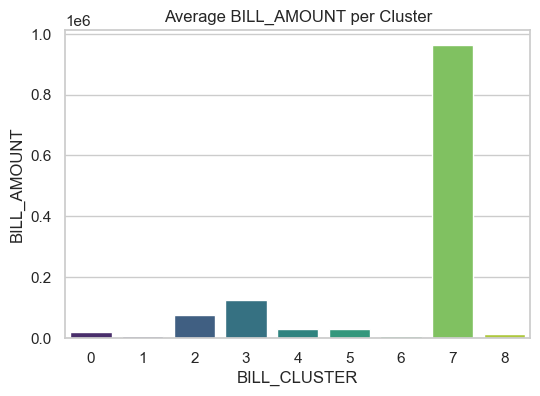

In [45]:
cluster_means = X_clusters.groupby("BILL_CLUSTER")["BILL_AMOUNT"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=cluster_means, x="BILL_CLUSTER", y="BILL_AMOUNT", palette="viridis")
plt.title("Average BILL_AMOUNT per Cluster")
plt.show()

This is a simple way to compare billing patterns across clusters. It helps identify which groups of customers or zones may need further investigation for anomalies or efficiency improvements.

In [46]:
X_clusters.groupby("BILL_CLUSTER")["BILL_AMOUNT"].mean()

BILL_CLUSTER
0     18336.069888
1      7882.738781
2     75176.197444
3    124060.257506
4     28836.374834
5     30175.806614
6      5378.860277
7    964036.621595
8     13011.494849
Name: BILL_AMOUNT, dtype: float64

<Axes: xlabel='BILL_AMOUNT', ylabel='Count'>

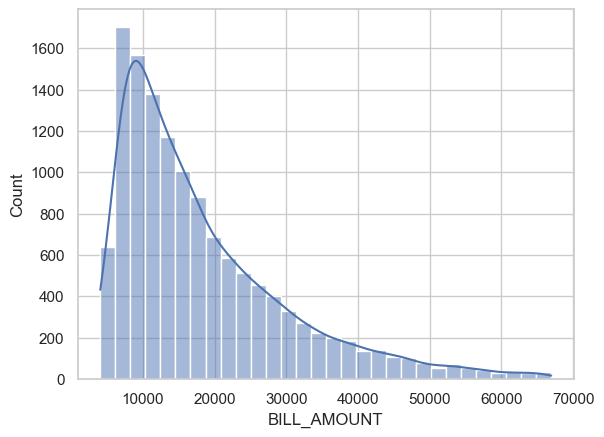

In [47]:
import seaborn as sns

cluster_0 = X_clusters[X_clusters['BILL_CLUSTER'] == 0]

sns.histplot(cluster_0["BILL_AMOUNT"], bins=30, kde=True)


This plot helps you understand billing behavior within a specific cluster and spot anomalies.

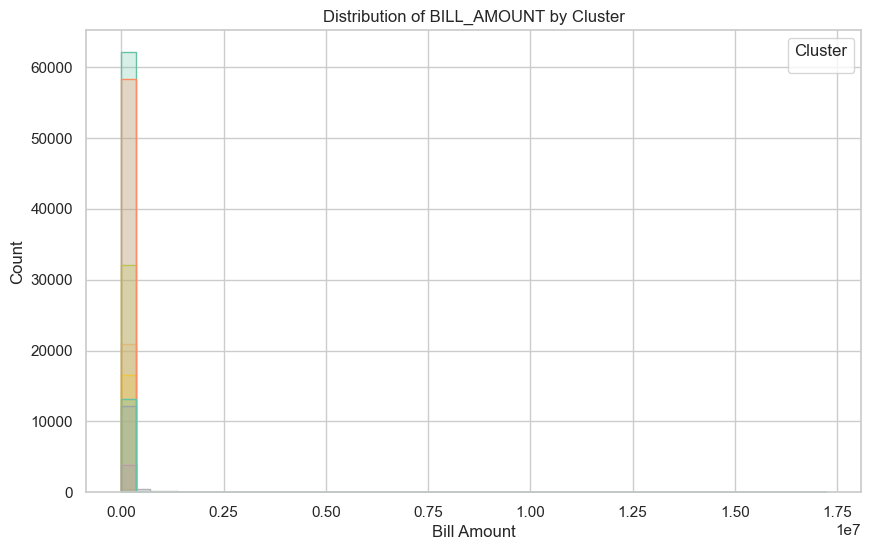

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(data=X_clusters, x="BILL_AMOUNT", hue="BILL_CLUSTER",
             bins=50, kde=False, palette="Set2", element="step")
plt.title("Distribution of BILL_AMOUNT by Cluster")
plt.xlabel("Bill Amount")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()


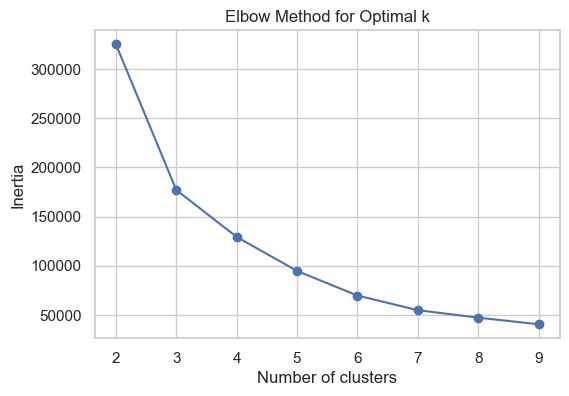

          BILL_VOLUME  WATER_AMOUNT  SEWER_AMOUNT
CLUSTER                                          
0          203.933994  1.479416e+04  7.683369e+03
1        18814.831135  1.286498e+06  4.959777e+05
2        71168.484848  5.692209e+06  3.841137e+06


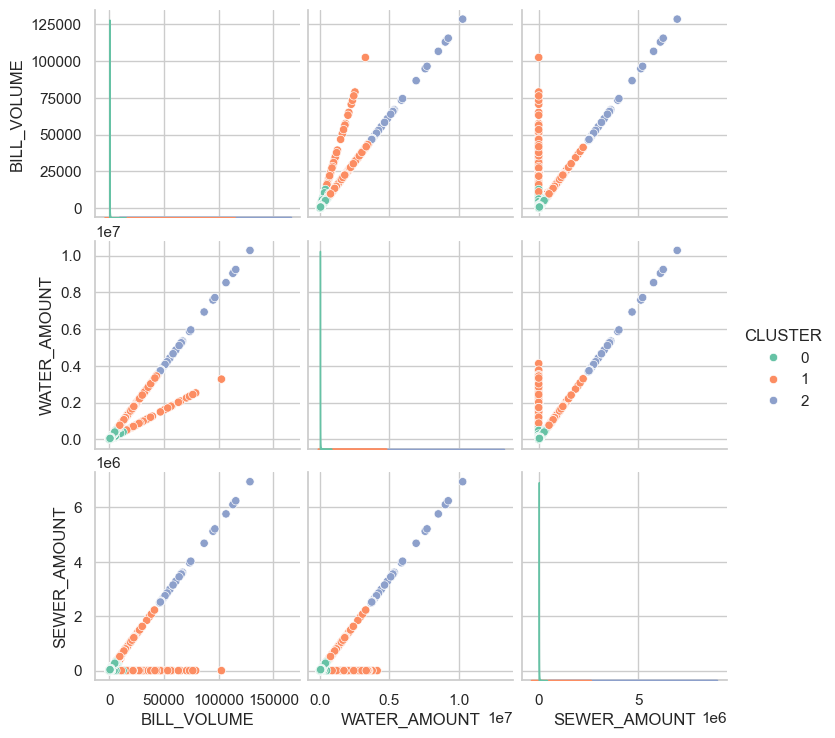

Potential abnormal clusters:
           BILL_VOLUME  WATER_AMOUNT  SEWER_AMOUNT
CLUSTER                                          
0          203.933994  1.479416e+04  7.683369e+03
1        18814.831135  1.286498e+06  4.959777e+05
2        71168.484848  5.692209e+06  3.841137e+06


In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features to cluster on
features = ["BILL_VOLUME", "WATER_AMOUNT", "SEWER_AMOUNT"]
X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (optional but recommended)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# From the elbow plot, pick k (e.g., k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['CLUSTER'] = kmeans.fit_predict(X_scaled)

# Examine cluster statistics
cluster_summary = df.groupby('CLUSTER')[features].mean()
print(cluster_summary)

# Optional: visualize clusters
sns.pairplot(df, vars=features, hue='CLUSTER', palette='Set2')
plt.show()

# Identify abnormal clusters
# For example, clusters with very low billed volume vs water usage
abnormal_clusters = cluster_summary[cluster_summary["BILL_VOLUME"] < cluster_summary["WATER_AMOUNT"] * 0.8]
print("Potential abnormal clusters:\n", abnormal_clusters)


# Gaussian Mixture Models (GMM)

What is GMM?

A probabilistic clustering method that models data as a combination of multiple Gaussian distributions.

Unlike K-Means, which assigns each point to exactly one cluster, GMM gives probabilities of belonging to each cluster (soft clustering).

Key Advantages:

Handles clusters of different shapes and sizes (elliptical, not just spherical).

More flexible when clusters overlap.

Provides probabilistic assignments, useful for identifying borderline or uncertain cases.

How it works:

Assumes data is generated from k Gaussian distributions.

Uses the Expectation-Maximization (EM) algorithm to estimate cluster parameters (means, covariances, and weights).

Assigns points to clusters based on highest probability.

Model Selection:

The number of clusters (k) can be chosen using BIC (Bayesian Information Criterion) or AIC (Akaike Information Criterion) — lower scores indicate a better fit with fewer penalties for complexity.

Business Relevance in Billing Data:

Helps identify customer segments with distinct consumption/billing patterns.

Useful when billing data shows overlapping behaviors (e.g., small businesses vs. large domestic users).

The probabilistic nature helps flag customers with uncertain billing patterns (potential anomalies).

In [50]:
# Select billing features
billing_features = ["WATER_AMOUNT", "SEWER_AMOUNT", "BILL_AMOUNT", "BILL_VOLUME"]
X = df[billing_features].fillna(0).values


In [51]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

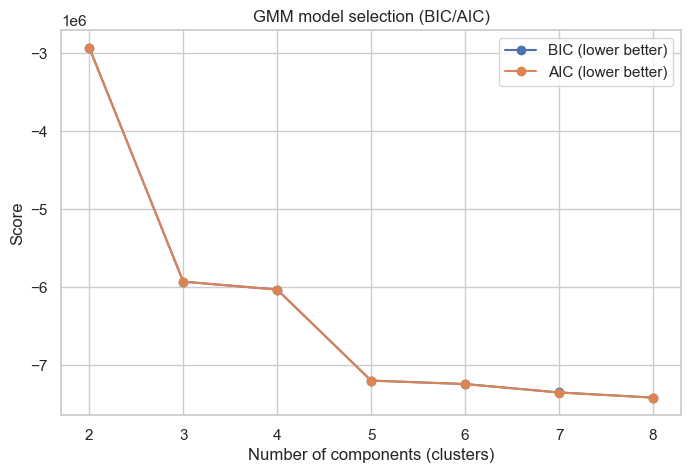

In [52]:
#  Step 1: Select number of clusters using BIC/AIC 

n_components = range(2, 9)
bics = []
aics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.figure(figsize=(8,5))
plt.plot(n_components, bics, marker='o', label="BIC (lower better)")
plt.plot(n_components, aics, marker='o', label="AIC (lower better)")
plt.title("GMM model selection (BIC/AIC)")
plt.xlabel("Number of components (clusters)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
#  Step 2: Fit final GMM with optimal k 
best_k = n_components[np.argmin(bics)]  # pick k with lowest BIC
final_gmm = GaussianMixture(n_components=best_k, random_state=42)
df["gmm_cluster"] = final_gmm.fit_predict(X_scaled)

print(f"Best number of clusters by BIC: {best_k}")

Best number of clusters by BIC: 8


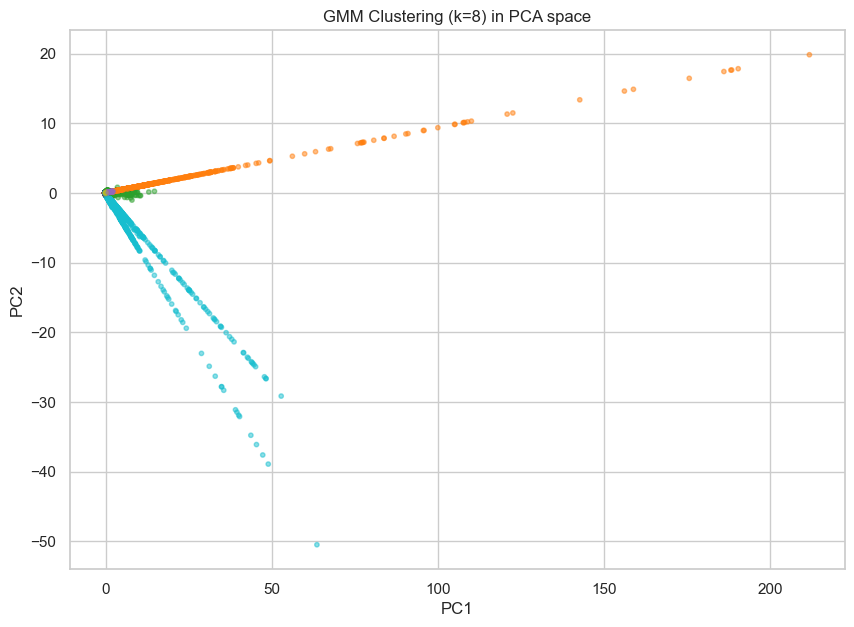

In [54]:
#  Step 3: Visualize in PCA space 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["gmm_cluster"], cmap="tab10", alpha=0.5, s=10)
plt.title(f"GMM Clustering (k={best_k}) in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [55]:
#  Step 4: Cluster profiles (means in original scale) 
cluster_profiles = df.groupby("gmm_cluster")[billing_features].mean()
print("Cluster profiles (original scale):")
print(cluster_profiles)

Cluster profiles (original scale):
              WATER_AMOUNT   SEWER_AMOUNT    BILL_AMOUNT  BILL_VOLUME
gmm_cluster                                                          
0              5636.330059    3578.778240    9215.108299    80.710235
1            425071.086384  285819.961445  710891.047828  5329.389946
2             79127.771953   49686.004277  130203.078035  1170.754017
3             50521.958000   33038.821074   83560.779074   647.739593
4              8560.198907       0.003672    8560.202579   118.552153
5             15085.986135    9539.699689   24625.685824   232.765727
6             13643.622903    8687.240089   22330.862992   183.772913
7            102208.552646       0.000000  102208.552646  1843.286316


## **Predictive Modeling**


In [56]:
# Import Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb


In [61]:
#  Feature selection
billing_features = ["WATER_AMOUNT","SEWER_AMOUNT","BILL_AMOUNT","BILL_VOLUME"]
extra_numeric = []   # add extra numeric cols if useful
cat_features = ["REGION","INST_TYPE_CODE"]  # adjust to your dataset

numeric_cols = billing_features + extra_numeric
categorical_cols = cat_features + ["BILL_CLUSTER"] if "BILL_CLUSTER" in df.columns else cat_features

In [63]:
# Target encoding
le = LabelEncoder()
df["BILL_VALID_BINARY"] = le.fit_transform(df["BILL_VALID_INVALID"].astype(str)) 

# Features / target
X = df[numeric_cols + categorical_cols]
y = df["BILL_VALID_BINARY"]

In [65]:
# Prepare Data

# Select features
features = ["METER_SIZE", "REGION", "ZONE", "SUB_ZONE", "WATER_AMOUNT", "SEWER_AMOUNT"]  
target_reg = "BILL_VOLUME"  

# Fill missing values
df[features] = df[features].fillna(0)
df[target_reg] = df[target_reg].fillna(df[target_reg].median())

# Encode categorical features
categorical_cols = ["REGION", "ZONE", "SUB_ZONE"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale numeric features for regression
numeric_cols = ["METER_SIZE", "WATER_AMOUNT", "SEWER_AMOUNT"]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Create classification target (High loss if BILL_VOLUME > 95th percentile)
df["High_Loss"] = (df["BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)


In [66]:
# split Data 

# Regression
X_reg = df[features]
y_reg = df[target_reg]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Classification
X_cls = df[features]
y_cls = df["High_Loss"]
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [67]:
#  Regresion Model

lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
y_pred_lr = lr.predict(X_test_reg)

print("Linear Regression MAE:", mean_absolute_error(y_test_reg, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test_reg, y_pred_lr))


Linear Regression MAE: 32.79035645904191
Linear Regression RMSE: 323.91446738461235
Linear Regression R2: 0.9266154333783994


In [68]:
# Random Forest Regressor  

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_reg, y_train_reg)
y_pred_rf = rf.predict(X_test_reg)

print("Random Forest MAE:", mean_absolute_error(y_test_reg, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test_reg, y_pred_rf))


Random Forest MAE: 7.235939747168014
Random Forest RMSE: 139.41447492258894
Random Forest R2: 0.9864056083741115


In [69]:
# classification
# logistic regresion

log = LogisticRegression(max_iter=500)
log.fit(X_train_cls, y_train_cls)
y_pred_log = log.predict(X_test_cls)

print("Logistic Regression Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print(classification_report(y_test_cls, y_pred_log))


Logistic Regression Accuracy: 0.9974655472833835
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       1.00      0.95      0.97      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.98      0.99     44191
weighted avg       1.00      1.00      1.00     44191



In [70]:
# Random classifier

rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls, y_train_cls)
y_pred_rf_cls = rf_cls.predict(X_test_cls)

print("Random Forest Accuracy:", accuracy_score(y_test_cls, y_pred_rf_cls))
print(classification_report(y_test_cls, y_pred_rf_cls))


Random Forest Accuracy: 0.9988685478943676
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.99      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



In [71]:
# XGboost Classifier

xgb_cls = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_xgb = xgb_cls.predict(X_test_cls)

print("XGBoost Accuracy:", accuracy_score(y_test_cls, y_pred_xgb))
print(classification_report(y_test_cls, y_pred_xgb))


XGBoost Accuracy: 0.9984159670521147
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.98      2167

    accuracy                           1.00     44191
   macro avg       0.99      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



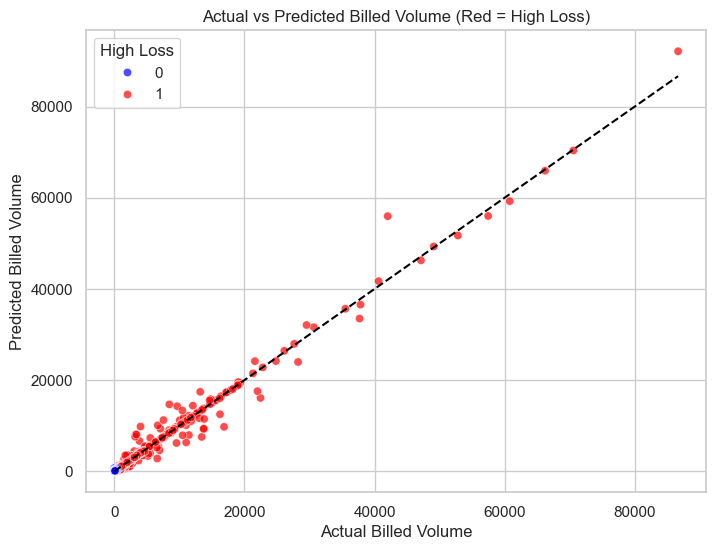

In [72]:
# Scatter Plot of Actual vs Predicted


import matplotlib.pyplot as plt
import seaborn as sns

# Add predicted values to the test set
df_test = X_test_reg.copy()
df_test["Actual_BILL_VOLUME"] = y_test_reg.values
df_test["Predicted_BILL_VOLUME"] = y_pred_rf
df_test["High_Loss"] = (df_test["Actual_BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.plot([df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         [df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")  # diagonal line for perfect prediction
plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Actual vs Predicted Billed Volume (Red = High Loss)")
plt.legend(title="High Loss")
plt.show()

Blue points = normal billed volumes

Red points = high-loss (top 5%)

The black dashed line = perfect prediction line (actual = predicted)

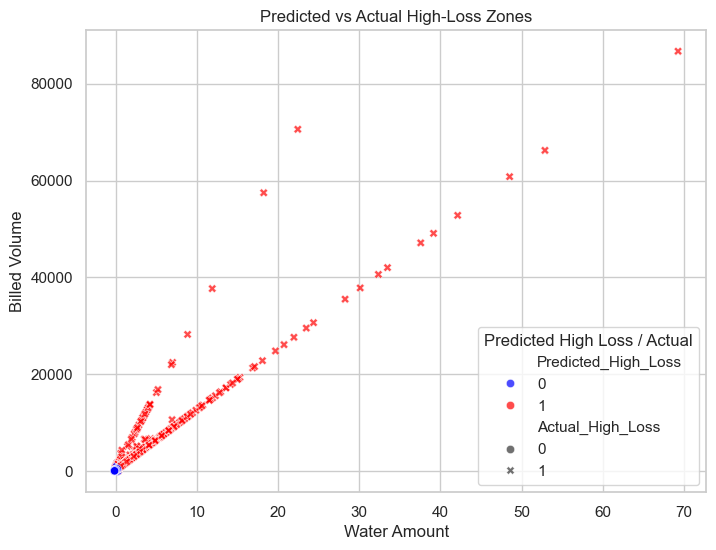

In [73]:
# Add classification predictions to the test set
df_test_cls = X_test_cls.copy()
df_test_cls["Actual_High_Loss"] = y_test_cls.values
df_test_cls["Predicted_High_Loss"] = y_pred_xgb

# Scatter plot using WATER_AMOUNT vs BILL_VOLUME for visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test_cls,
    x=X_test_cls["WATER_AMOUNT"],
    y=y_test_reg.loc[X_test_cls.index],  # match actual billed volume for y-axis
    hue="Predicted_High_Loss",
    style="Actual_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.xlabel("Water Amount")
plt.ylabel("Billed Volume")
plt.title("Predicted vs Actual High-Loss Zones")
plt.legend(title="Predicted High Loss / Actual")
plt.show()


Color: Red = predicted high-loss, Blue = predicted low-loss

Marker style: Distinguishes actual high-loss vs low-loss points

This helps you quickly see false positives and false negatives, i.e., where the model misclassifies zones

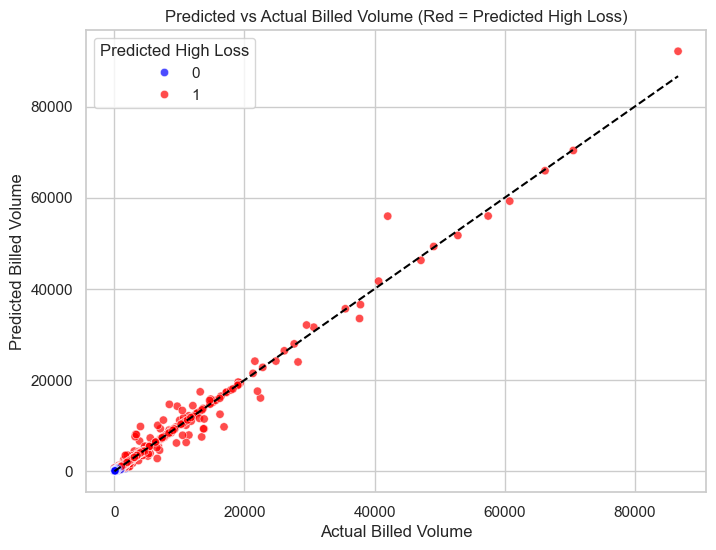

In [74]:
# Combine regression predictions and classification predictions
df_combined = X_test_reg.copy()
df_combined["Actual_BILL_VOLUME"] = y_test_reg.values
df_combined["Predicted_BILL_VOLUME"] = y_pred_rf
df_combined["Predicted_High_Loss"] = y_pred_xgb  # predicted by classification model

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_combined,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="Predicted_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
# Diagonal line for perfect prediction
plt.plot([df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         [df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")

plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Predicted vs Actual Billed Volume (Red = Predicted High Loss)")
plt.legend(title="Predicted High Loss")
plt.show()


Red points: Zones predicted to be high-loss by XGBoost

Blue points: Predicted low-loss zones

Black dashed line: Perfect prediction reference